In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

from scipy.spatial.transform import Rotation as R

from src.learners.learner_base import LearnerBase
from src.models.nn_model import NNAUVModel

from src.model import get_model
from src.learner import get_learner

import pandas as pd
import numpy as np
import bagpy
from bagpy import bagreader

import os
from tqdm import tqdm


import matplotlib.pyplot as plt
%matplotlib inline


# Create Model and Learner.


In [2]:
modelQuat = get_model(model_dict={"type": "auv_nn",
                                 "mask": [[1], [1], [1],
                                          [0], [0], [0], [0],
                                          [0], [0], [0],
                                          [0], [0], [0]]},
                      samples=tf.Variable(1),
                      dt=0.1,
                      state_dim=13,
                      action_dim=6,
                      name="learn_test")

modelEuler = get_model(model_dict={"type": "auv_nn",
                                   "mask": [[1], [1], [1],
                                            [0], [0], [0],
                                            [0], [0], [0],
                                            [0], [0], [0]]},
                       samples=tf.Variable(1),
                       dt=0.1,
                       state_dim=12,
                       action_dim=6,
                       name="learn_test")

learnerQuat = get_learner(modelQuat,
                          bufferSize=250*500,
                          log=True,
                          logPath="./LearnerQuatTests/")

learnerEuler = get_learner(modelEuler,
                           bufferSize=250*500,
                           log=True,
                           logPath="./learnerEulerTests/")

dataDir = '../../../log/data/15.02.2022'
valDir = '../../../log/data_val/'

# Load data

- load data from file.
- Create a learning set and validat

In [3]:
data = os.path.join(dataDir, 'run{}.bag')
val = os.path.join(valDir, 'run{}.bag')

# Compute required step size and compare it to the rosbag

    dt = 0.1
need to interpolate the data such that we have samples at ~10hz.


# Feed the data to the learner.
 - Need to resample the data such that the data frequency is ~10Hz.
 - Feed the transition to the learner.


In [4]:
def get_state(stateDf):
    state = np.zeros(13)
    
    # Position
    state[0] = stateDf['pose.pose.position.x']
    state[1] = stateDf['pose.pose.position.y']
    state[2] = stateDf['pose.pose.position.z']
    # Quaternion
    state[3] = stateDf['pose.pose.orientation.x']
    state[4] = stateDf['pose.pose.orientation.y']
    state[5] = stateDf['pose.pose.orientation.z']
    state[6] = stateDf['pose.pose.orientation.w']
    # Linear Velocity
    state[7] = stateDf['twist.twist.linear.x']
    state[8] = stateDf['twist.twist.linear.y']
    state[9] = stateDf['twist.twist.linear.z']
    # Angular Velocity
    state[10] = stateDf['twist.twist.angular.x']
    state[11] = stateDf['twist.twist.angular.y']
    state[12] = stateDf['twist.twist.angular.z']
    
    return state

def to_euler(state):
    newState = np.zeros(12)
    quats = state[3:7]
    r = R.from_quat(quats)
    euler = r.as_euler('xyz', True)
    newState[3] = euler[0] # Roll
    newState[4] = euler[1] # Pitch
    newState[5] = euler[2] # Yaw

    newState[:3] = state[:3] # position
    newState[6:] = state[7:] # velocities
    return newState

def get_action(actionDf):
    action = np.zeros(6)
    # Linear force
    action[0] = actionDf['wrench.force.x']
    action[1] = actionDf['wrench.force.y']
    action[2] = actionDf['wrench.force.z']
    # Torque
    action[3] = actionDf['wrench.torque.x']
    action[4] = actionDf['wrench.torque.y']
    action[5] = actionDf['wrench.torque.z']
    return action

def feed_learner(learner, directory, quat=True):
    trajs = 500
    #trajs = 1
    for i in tqdm(range(trajs)):
        # Read the bag.
        data = os.path.join(dataDir, 'run{}.bag'.format(i))
        bag = bagreader(data, verbose=False)
        pose = pd.read_csv(bag.message_by_topic('/rexrov2/pose_gt'))
        action = pd.read_csv(bag.message_by_topic('/thruster_input'))
        
        # Resample the datapoints to have a 10Hz frequency
        intPose = pose.copy()

        intPose['time'] = pd.to_datetime(pose['Time'], unit='s').round('ms')

        intPoseUp = intPose.set_index('time').resample('ms').interpolate('linear').resample('0.1S').agg('first')
        intPoseUp.drop(intPoseUp.index[0], inplace=True)

        intAction = action.copy()
        intAction = intAction.drop(action.index[-1])
        intAction['Time'] = pd.to_datetime(intAction["Time"], unit='s').round('ms')

        # For some black magic reason the resamples doesn't seem to work with the aciton frame.
        intActionUp = intAction.set_index('Time').resample('ms').interpolate('linear').resample('0.1S').agg('first').reset_index()
        
        #if intActionUp['Time'].shape != intPoseUp['Time'].shape:
            #print("Error do not have the same number of samples for the pose and the action")

        for j in range(intPoseUp['Time'].shape[0]-1):
            state = get_state(intPoseUp.iloc[j])
            next_state = get_state(intPoseUp.iloc[j+1])
            act = get_action(intActionUp.iloc[j])
            if not quat:
                state = to_euler(state)
                next_state = to_euler(next_state)
            learner.add_rb(state, act, next_state)

In [5]:
feed_learner(learnerQuat, dataDir)

feed_learner(learnerEuler, dataDir, quat=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:19<00:00,  2.51it/s]


In [6]:
fooQuat = learnerQuat.rb_trans()
sQuat = fooQuat['obs'].shape

fooEuler = learnerEuler.rb_trans()
sEuler = fooEuler['obs'].shape

print(sQuat[0])
print(sQuat[0]*0.1 / 60 / 60)
print(((sQuat[0]*0.1 / 60 / 60)-3)*60)
print((((((sQuat[0]*0.1 / 60 / 60)-3)*60))-27)*60)

124685
3.4634722222222223
27.808333333333337
48.50000000000023


In [7]:
learnerQuat.stats()
learnerEuler.stats()

In [8]:
dataQuat = learnerQuat.rb_trans()
(XQuat, yQuat) = modelQuat.prepare_training_data(dataQuat['obs'],
                                                 dataQuat['next_obs'],
                                                 dataQuat['act'])
XQuat = np.squeeze(XQuat)
yQuat = np.squeeze(yQuat)

dataEuler = learnerEuler.rb_trans()
(XEuler, yEuler) = modelEuler.prepare_training_data(dataEuler['obs'],
                                                    dataEuler['next_obs'],
                                                    dataEuler['act'])
XEuler = np.squeeze(XEuler)
yEuler = np.squeeze(yEuler)

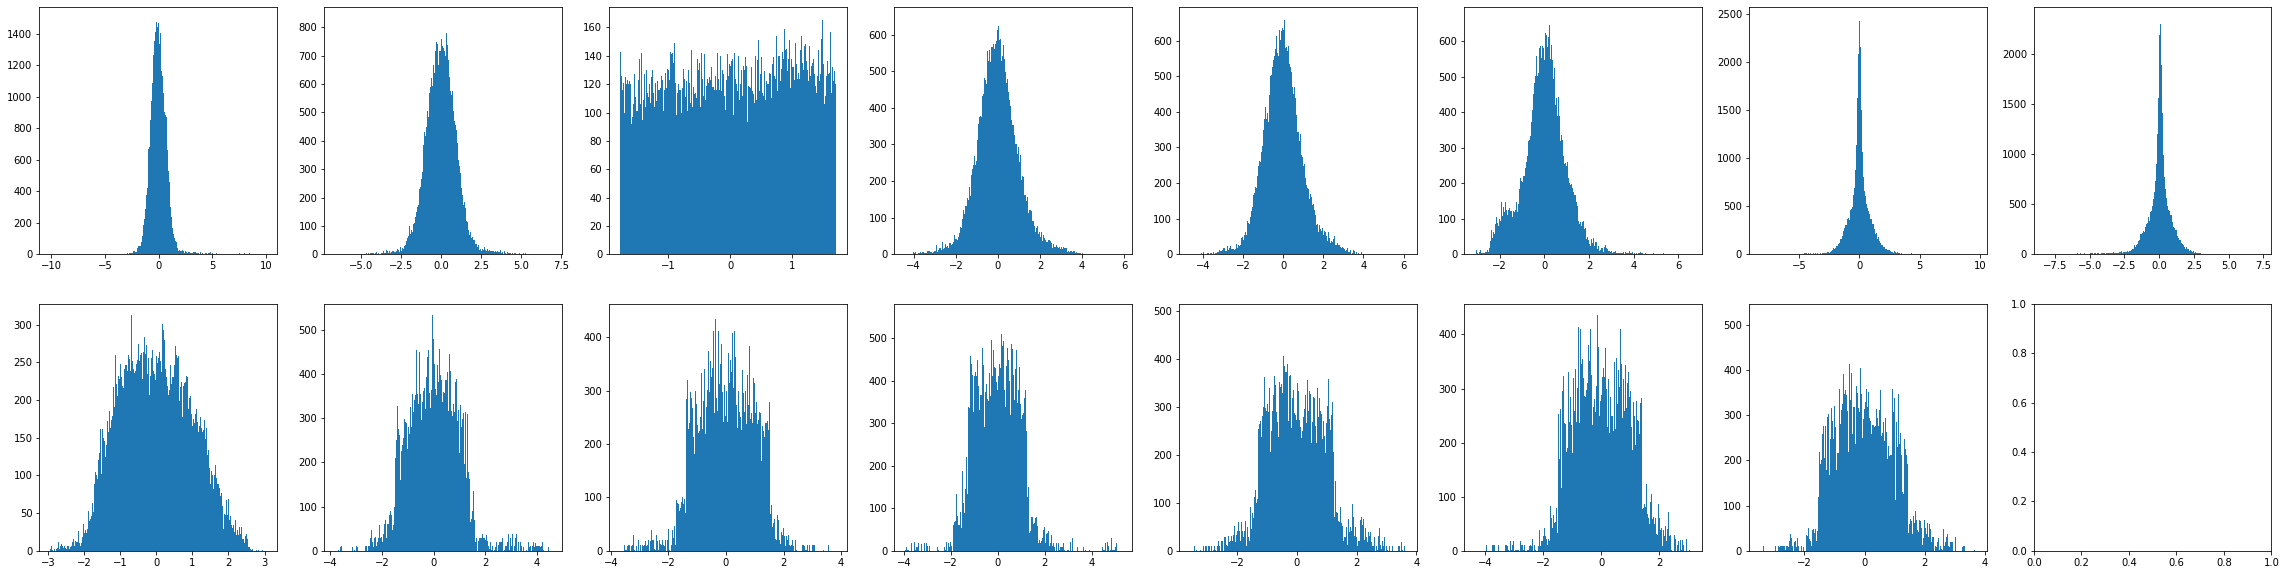

In [9]:
fig, ax = plt.subplots(figsize=(40, 10), nrows=2, ncols=8)
_ = ax[0, 0].hist(XEuler[:, 0], bins=1000)
_ = ax[0, 1].hist(XEuler[:, 1], bins=1000)
_ = ax[0, 2].hist(XEuler[:, 2], bins=1000)
_ = ax[0, 3].hist(XEuler[:, 3], bins=1000)
_ = ax[0, 4].hist(XEuler[:, 4], bins=1000)
_ = ax[0, 5].hist(XEuler[:, 5], bins=1000)
_ = ax[0, 6].hist(XEuler[:, 6], bins=1000)
_ = ax[0, 7].hist(XEuler[:, 7], bins=1000)
_ = ax[1, 0].hist(XEuler[:, 8], bins=1000)
_ = ax[1, 1].hist(XEuler[:, 9], bins=1000)
_ = ax[1, 2].hist(XEuler[:, 10], bins=1000)
_ = ax[1, 3].hist(XEuler[:, 11], bins=1000)
_ = ax[1, 4].hist(XEuler[:, 12], bins=1000)
_ = ax[1, 5].hist(XEuler[:, 13], bins=1000)
_ = ax[1, 6].hist(XEuler[:, 14], bins=1000)

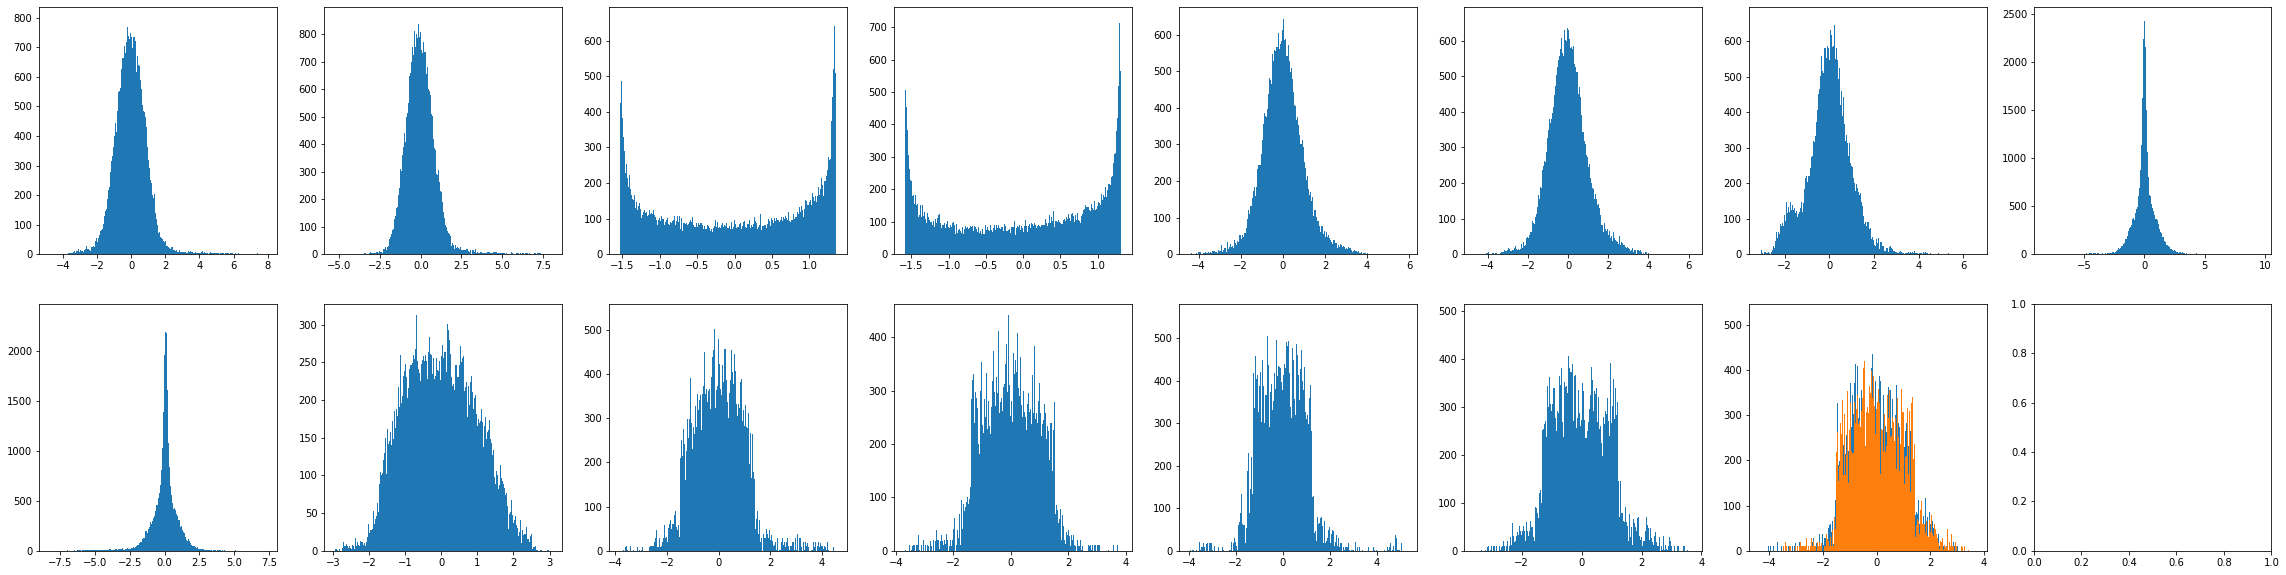

In [10]:
fig, ax = plt.subplots(figsize=(40, 10), nrows=2, ncols=8)
_ = ax[0, 0].hist(XQuat[:, 0], bins=1000)
_ = ax[0, 1].hist(XQuat[:, 1], bins=1000)
_ = ax[0, 2].hist(XQuat[:, 2], bins=1000)
_ = ax[0, 3].hist(XQuat[:, 3], bins=1000)
_ = ax[0, 4].hist(XQuat[:, 4], bins=1000)
_ = ax[0, 5].hist(XQuat[:, 5], bins=1000)
_ = ax[0, 6].hist(XQuat[:, 6], bins=1000)
_ = ax[0, 7].hist(XQuat[:, 7], bins=1000)
_ = ax[1, 0].hist(XQuat[:, 8], bins=1000)
_ = ax[1, 1].hist(XQuat[:, 9], bins=1000)
_ = ax[1, 2].hist(XQuat[:, 10], bins=1000)
_ = ax[1, 3].hist(XQuat[:, 11], bins=1000)
_ = ax[1, 4].hist(XQuat[:, 12], bins=1000)
_ = ax[1, 5].hist(XQuat[:, 13], bins=1000)
_ = ax[1, 6].hist(XQuat[:, 14], bins=1000)
_ = ax[1, 6].hist(XQuat[:, 15], bins=1000)

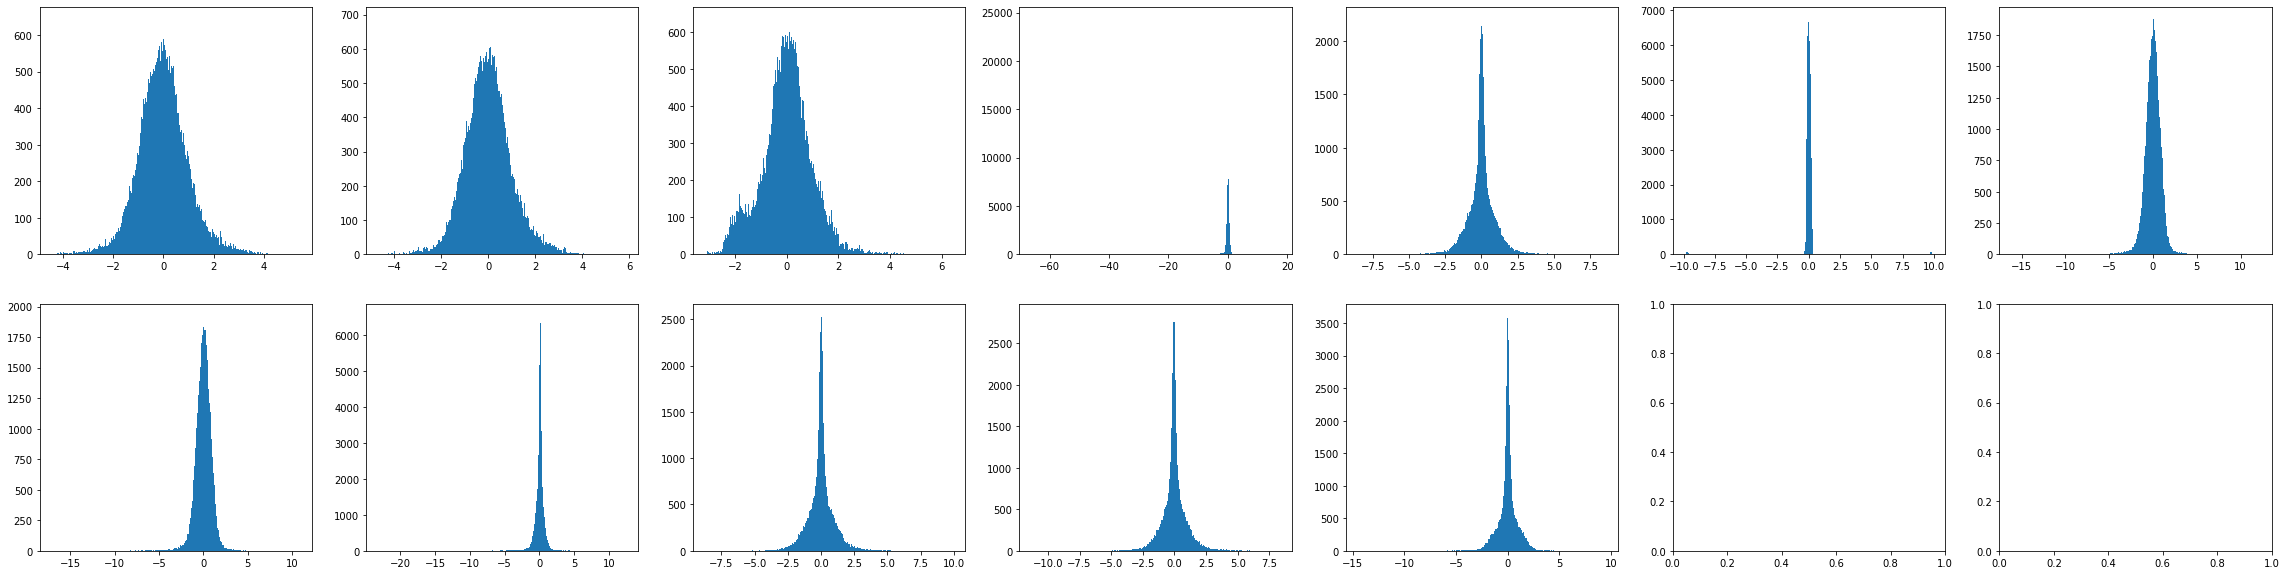

In [11]:
fig, ax = plt.subplots(figsize=(40, 10), nrows=2, ncols=7)
_ = ax[0, 0].hist(yEuler[:, 0], bins=1000)
_ = ax[0, 1].hist(yEuler[:, 1], bins=1000)
_ = ax[0, 2].hist(yEuler[:, 2], bins=1000)
_ = ax[0, 3].hist(yEuler[:, 3], bins=1000)
_ = ax[0, 4].hist(yEuler[:, 4], bins=1000)
_ = ax[0, 5].hist(yEuler[:, 5], bins=1000)
_ = ax[0, 6].hist(yEuler[:, 6], bins=1000)
_ = ax[1, 0].hist(yEuler[:, 7], bins=1000)
_ = ax[1, 1].hist(yEuler[:, 8], bins=1000)
_ = ax[1, 2].hist(yEuler[:, 9], bins=1000)
_ = ax[1, 3].hist(yEuler[:, 10], bins=1000)
_ = ax[1, 4].hist(yEuler[:, 11], bins=1000)

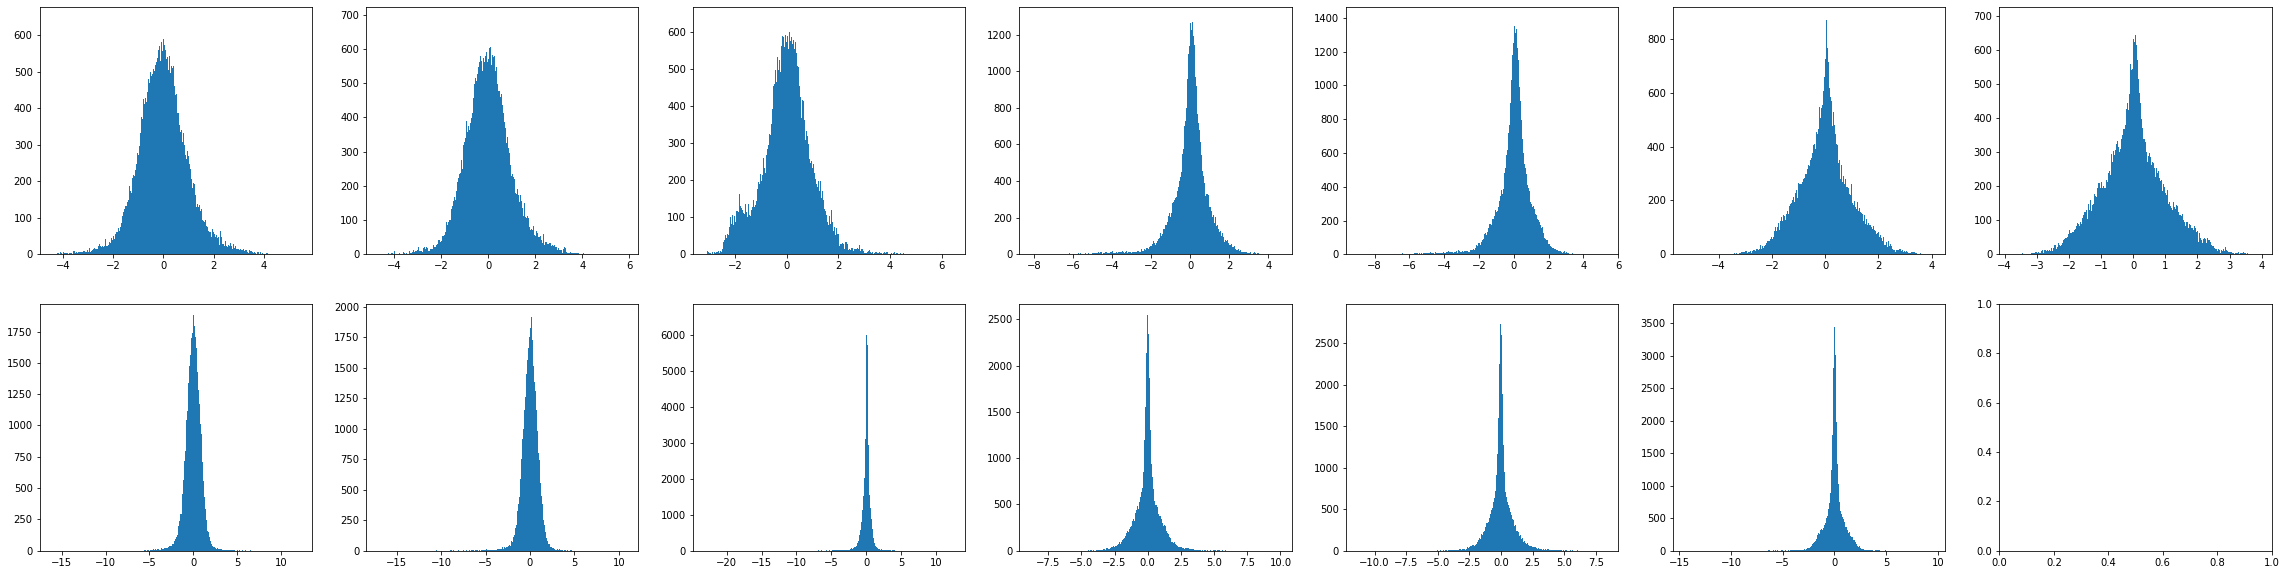

In [12]:
fig, ax = plt.subplots(figsize=(40, 10), nrows=2, ncols=7)
_ = ax[0, 0].hist(yQuat[:, 0], bins=1000)
_ = ax[0, 1].hist(yQuat[:, 1], bins=1000)
_ = ax[0, 2].hist(yQuat[:, 2], bins=1000)
_ = ax[0, 3].hist(yQuat[:, 3], bins=1000)
_ = ax[0, 4].hist(yQuat[:, 4], bins=1000)
_ = ax[0, 5].hist(yQuat[:, 5], bins=1000)
_ = ax[0, 6].hist(yQuat[:, 6], bins=1000)
_ = ax[1, 0].hist(yQuat[:, 7], bins=1000)
_ = ax[1, 1].hist(yQuat[:, 8], bins=1000)
_ = ax[1, 2].hist(yQuat[:, 9], bins=1000)
_ = ax[1, 3].hist(yQuat[:, 10], bins=1000)
_ = ax[1, 4].hist(yQuat[:, 11], bins=1000)
_ = ax[1, 5].hist(yQuat[:, 12], bins=1000)

In [13]:
def to_euler_batch(states):
    newStates = np.zeros((states.shape[0], 12))
    quats = states[:, 3:7]
    r = R.from_quat(quats)
    euler = r.as_euler('xyz', True)
    newStates[:,3] = euler[:, 0] # Roll
    newStates[:, 4] = euler[:, 1] # Pitch
    newStates[:, 5] = euler[:, 2] # Yaw

    newStates[:, :3] = states[:, :3] # position
    newStates[:, 6:] = states[:, 7:] # velocities
    return newStates


def validation(valDir, nbRuns, quat=True):
    data = os.path.join(valDir, 'run{}.bag')
    trajs = [] 
    actionSeqs = [] 
    for i in range(nbRuns):
        file = data.format(i)
        
        bag = bagreader(file, verbose=False)
        pose = pd.read_csv(bag.message_by_topic('/rexrov2/pose_gt'))
        action = pd.read_csv(bag.message_by_topic('/thruster_input'))

        # Resample the datapoints to have a 10Hz frequency
        intPose = pose.copy()
        
        intPose['time'] = pd.to_datetime(pose['Time'], unit='s').round('ms')

        intPoseUp = intPose.set_index('time').resample('ms').interpolate('linear').resample('0.1S').agg('first')
        intPoseUp.drop(intPoseUp.index[0], inplace=True)

        intAction = action.copy()
        intAction = intAction.drop(action.index[-1])
        intAction['Time'] = pd.to_datetime(intAction["Time"], unit='s').round('ms')

        # For some black magic reason the resamples doesn't seem to work with the aciton frame.
        intActionUp = intAction.set_index('Time').resample('ms').interpolate('linear').resample('0.1S').agg('first').reset_index()

        traj = np.zeros(shape=(intPoseUp['Time'].shape[0], 13))
        actionSeq = np.zeros(shape=(intActionUp['Time'].shape[0], 6))

        traj[:, 0] = intPoseUp['pose.pose.position.x']
        traj[:, 1] = intPoseUp['pose.pose.position.y']
        traj[:, 2] = intPoseUp['pose.pose.position.z']
    
        traj[:, 3] = intPoseUp['pose.pose.orientation.x']
        traj[:, 4] = intPoseUp['pose.pose.orientation.x']
        traj[:, 5] = intPoseUp['pose.pose.orientation.x']
        traj[:, 6] = intPoseUp['pose.pose.orientation.x']

        traj[:, 7] = intPoseUp['twist.twist.linear.x']
        traj[:, 8] = intPoseUp['twist.twist.linear.y']
        traj[:, 9] = intPoseUp['twist.twist.linear.z']

        traj[:, 10] = intPoseUp['twist.twist.angular.x']
        traj[:, 11] = intPoseUp['twist.twist.angular.y']
        traj[:, 12] = intPoseUp['twist.twist.angular.z']

        actionSeq[:, 0] = intActionUp['wrench.force.x']    
        actionSeq[:, 1] = intActionUp['wrench.force.y']
        actionSeq[:, 2] = intActionUp['wrench.force.z']

        actionSeq[:, 3] = intActionUp['wrench.torque.x']
        actionSeq[:, 4] = intActionUp['wrench.torque.y']
        actionSeq[:, 5] = intActionUp['wrench.torque.z']
        
        if not quat:
            traj = to_euler_batch(traj)

        trajs.append(np.expand_dims(traj, axis=0))
        actionSeqs.append(np.expand_dims(actionSeq, axis=0))
    trajs = np.concatenate(trajs, axis=0)
    actionSeqs = np.concatenate(actionSeqs, axis=0)
    return trajs, actionSeqs


In [14]:
trajsQuat, actionSeqsQuat = validation(valDir, 19)
trajsEuler, actionSeqsEuler = validation(valDir, 19, quat=False)
print(actionSeqsQuat.shape)
print(actionSeqsEuler.shape)

(19, 250, 6)
(19, 250, 6)


In [15]:
print("*"*5, " Position ", "*"*5)
print(np.max(np.abs(trajsQuat[:, :, 0]-trajsEuler[:, :, 0])))
print(np.max(np.abs(trajsQuat[:, :, 1]-trajsEuler[:, :, 1])))
print(np.max(np.abs(trajsQuat[:, :, 2]-trajsEuler[:, :, 2])))

print("*"*5, " Lin Vel ", "*"*5)
print(np.max(np.abs(trajsQuat[:, :, 7]-trajsEuler[:, :, 6])))
print(np.max(np.abs(trajsQuat[:, :, 8]-trajsEuler[:, :, 7])))
print(np.max(np.abs(trajsQuat[:, :, 9]-trajsEuler[:, :, 8])))

print("*"*5, " Ang Vel ", "*"*5)
print(np.max(np.abs(trajsQuat[:, :, 10]-trajsEuler[:, :, 9])))
print(np.max(np.abs(trajsQuat[:, :, 11]-trajsEuler[:, :, 10])))
print(np.max(np.abs(trajsQuat[:, :, 12]-trajsEuler[:, :, 11])))

*****  Position  *****
0.0
0.0
0.0
*****  Lin Vel  *****
0.0
0.0
0.0
*****  Ang Vel  *****
0.0
0.0
0.0


In [ ]:
learnerEuler.grid_search(trajsEuler, actionSeqsEuler)

*****  Grid  *****
lr:  0.0001
bs:  -1
e:  100
fold:  [2.103383398384868, 2.115571060239415, 2.0197834329011806, 2.0433786884104577, 1.996854167314248, 2.002118204984123, 1.962404890299963, 2.045410359103581, 2.0247647460483256, 2.073041374916095]
mean:  2.0386710322602255
validation error:  4048122491.60223
*****  Grid  *****
lr:  0.0001
bs:  -1
e:  500
fold:  [2.0351972662778928, 2.041738151731445, 2.108730651882832, 2.0676929462331355, 1.9578199647759529, 1.9521877057667019, 2.0237009181045944, 2.1408993704480355, 2.0092001856751427, 2.0495485989672195]
mean:  2.038671575986295
validation error:  174784.04070452735
*****  Grid  *****
lr:  0.0001
bs:  -1
e:  1000
fold:  [2.0507009172214508, 2.021381587948988, 2.0691050961781454, 2.077862962924744, 2.003450907588448, 2.0058914819018745, 2.0594278260542866, 1.9954499248095594, 2.100098062274314, 2.0033460848370663]
mean:  2.0386714851738876
validation error:  1503.2154312951398
*****  Grid  *****
lr:  0.0112
bs:  -1
e:  100
fold:  [2.1

In [ ]:
learnerQuat.grid_search(trajsQuat, actionSeqsQuat)